In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os


PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU count: 1
Using device: cuda


# Load dataset

In [2]:

from datasets import load_dataset

ds = load_dataset("argilla/cnn-dailymail-summaries", split='train')
print(ds)

Dataset({
    features: ['article', 'highlights', 'id', 'summary', 'distilabel_metadata', 'model_name'],
    num_rows: 287113
})


# Prepare data

In [3]:
articles = []
summaries = []
i = 0
for data in ds:
    articles.append(data['article'])
    summaries.append(data['highlights'])
    i += 1
    if i == 10000:
        break

# Get Tokenizer - BartTokenizer with 50265 vocab size

In [4]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
VOCAB_SIZE = tokenizer.vocab_size
SRC_MAX_SEQ = 1024
TGT_MAX_SEQ = 128


# Clean data

In [5]:
"""To set determined len for src and tgt --> also with pad tokens"""

inputs = [tokenizer.encode(str(sentence)) for sentence in articles]
outputs = [tokenizer.encode(str(sentence)) for sentence in summaries]


def clean_data(sentences, max_seq_length):
    for i, sentence in enumerate(sentences):
        if len(sentence) < max_seq_length:
            sentences[i] = sentence + [tokenizer.pad_token_id] * (max_seq_length - len(sentence))
        elif len(sentence) > max_seq_length:
            sentences[i] = sentence[:max_seq_length - 1] + [tokenizer.eos_token_id]


clean_data(inputs, SRC_MAX_SEQ)
clean_data(outputs, TGT_MAX_SEQ)

In [6]:
articles_inputs = torch.tensor(inputs)
summaries_outputs = torch.tensor(outputs)
assert len(articles_inputs) == len(summaries_outputs), "Number of articles and summaries must be the same"
print('Max src seq len:', SRC_MAX_SEQ)
print('Max tgt seq len:', TGT_MAX_SEQ)
print('Number of examples:', len(inputs))
print("Number of vocab size:", VOCAB_SIZE)


Max src seq len: 1024
Max tgt seq len: 128
Number of examples: 10000
Number of vocab size: 50265


# Custom Dataset and DataLoader with train and val data (80%, 20%)

In [7]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


dataset = CustomDataset(articles_inputs, summaries_outputs)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 8000
Number of validation samples: 2000


In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")


Number of batches in training set: 500
Number of batches in validation set: 125


In [9]:
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model  # Model's dimension
        self.num_heads = num_heads  # Number of attention heads
        self.d_k = d_model // num_heads  # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model)  # Query transformation
        self.W_k = nn.Linear(d_model, d_model)  # Key transformation
        self.W_v = nn.Linear(d_model, d_model)  # Value transformation
        self.W_o = nn.Linear(d_model, d_model)  # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [11]:
"""NOTE: There is no evidence that positional encoding is better than simple learnable embeddings."""


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [14]:
import sys


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                 max_tgt_seq_len, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.src_positional_encoding = PositionalEncoding(d_model, max_src_seq_len)
        self.tgt_positional_encoding = PositionalEncoding(d_model, max_tgt_seq_len)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(3)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        nopeak_mask = nopeak_mask.to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.src_positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.tgt_positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [15]:
src_vocab_size = VOCAB_SIZE
tgt_vocab_size = VOCAB_SIZE
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_src_seq_len = SRC_MAX_SEQ
max_tgt_seq_len = TGT_MAX_SEQ
dropout = 0.2

In [16]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                          max_tgt_seq_len,
                          dropout)
transformer.to(device)

Transformer(
  (encoder_embedding): Embedding(50265, 512)
  (decoder_embedding): Embedding(50265, 512)
  (src_positional_encoding): PositionalEncoding()
  (tgt_positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder_layers)

# Train model

In [ ]:
torch.manual_seed(42)
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

lr = 3e-4
optimizer = optim.AdamW(transformer.parameters(), lr=lr, betas=(0.9, 0.95), eps=1e-8)

num_epochs = 100
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

transformer.train()
lr_history = []
loss_history = []
i = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    epoch_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for src_data, tgt_data in progress_bar:
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        output = transformer(src_data, tgt_data[:, :-1])
        loss = F.cross_entropy(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1),
                               ignore_index=tokenizer.pad_token_id)
        lr_history.append(optimizer.param_groups[0]['lr'])
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)  # Prevent exploding gradients
        optimizer.step()

        optimizer.zero_grad()
        scheduler.step()
        # i += 1
        # if i == 100:
        #     break

        # Update progress bar with current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})
    print(f"Epoch: {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1:   1%|          | 4/500 [00:05<12:28,  1.51s/it, Batch Loss=4.61]

# Show charts with lr and loss

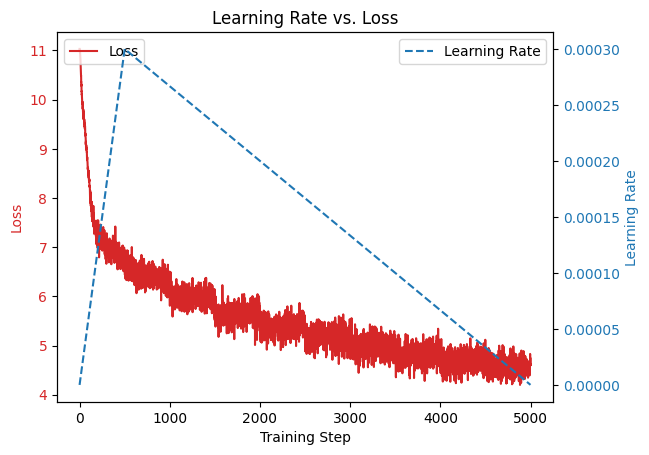

In [18]:
from matplotlib import pyplot as plt

# Ensure lr_history and loss_history are lists of equal length
assert len(lr_history) == len(loss_history), "Length of lr_history and loss_history must be the same"

fig, ax1 = plt.subplots()

# Plot Loss on primary y-axis
ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color='tab:red')
ax1.plot(range(len(loss_history)), loss_history, color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot Learning Rate on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color='tab:blue')
ax2.plot(range(len(lr_history)), lr_history, color='tab:blue', linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Calculate loss on validation data

In [19]:
transformer.eval()

total_val_loss = 0.0

with torch.no_grad():
    # Use tqdm for progress bar
    progress_bar = tqdm(val_loader, desc="Validating")

    for val_src_data, val_tgt_data in progress_bar:
        # Move data to GPU
        val_src_data, val_tgt_data = val_src_data.to(device), val_tgt_data.to(device)

        # Forward pass
        val_output = transformer(val_src_data, val_tgt_data[:, :-1])

        # Calculate loss
        val_loss = F.cross_entropy(
            val_output.contiguous().view(-1, tgt_vocab_size),
            val_tgt_data[:, 1:].contiguous().view(-1),
            ignore_index=tokenizer.pad_token_id
        )

        total_val_loss += val_loss.item()

        # Update progress bar with current batch loss
        progress_bar.set_postfix({"Batch Loss": val_loss.item()})

# Calculate average validation loss
avg_val_loss = total_val_loss / len(val_loader)
print(f"Average Validation Loss: {avg_val_loss:.4f}")

Validating: 100%|██████████| 125/125 [00:23<00:00,  5.38it/s, Batch Loss=5.7] 

Average Validation Loss: 5.6915


# Model inference

In [23]:
def generate_summary(sentence, tokenizer, model, max_length=TGT_MAX_SEQ):
    """
    Translates a single Polish sentence into Ukrainian using greedy decoding.
    """
    model.eval()  # Set the model to evaluation mode

    # Tokenize and convert to tensor
    tokens = tokenizer.encode(sentence)
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    # print(tokens)

    # Start with the input sentence and an empty target sequence
    src_data = tokens
    tgt_data = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            # Generate output (prediction for next token)
            output = model(src_data, tgt_data)

            # Get the last token's logits and find the token with the highest probability
            next_token_id = output[:, -1, :].argmax(dim=-1).item()

            # Append the predicted token to the target sequence
            tgt_data = torch.cat([tgt_data, torch.tensor([[next_token_id]]).to(device)], dim=1)

            # Stop if the model outputs the [SEP] token
            if next_token_id == tokenizer.eos_token_id:
                break

    # Decode the token ids back to the sentence
    translated_tokens = tgt_data.squeeze().tolist()
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


def inference_from_datasets(train_dataset: bool = True, index: int = 0):
    if train_dataset:
        dataset = train_loader.dataset
    else:
        dataset = val_loader.dataset
    article = tokenizer.decode(dataset[index][0].tolist(), skip_special_tokens=True)
    translation = generate_summary(article, tokenizer, transformer)

    print('Dataset:', 'Train' if train_dataset else 'Validation')
    print('Article:', article[:200])
    print('Generated translation:', translation)
    print('Real translation:', tokenizer.decode(dataset[index][1].tolist(), skip_special_tokens=True))


inference_from_datasets(train_dataset=True, index=0)

Dataset: Train
Article: Lourdes Batista wishes she had super powers so she could use them to find her husband, she said Wednesday, 105 days after authorities said he was kidnapped in Mexico. Lourdes Batista says she has no i
Generated translation: NEW: Police say they have been missing since Friday .
NEW: Suspect was found dead in a hospital after being shot, police say .
NEW: Suspect was found in a car crash in a Florida home, police say .
Police say suspect had been missing since May, police say .
Real translation: Lourdes Batista says of perplexing motive, "This is why I can't sleep at night"
Felix Batista was kidnapped December 10 outside a restaurant in Saltillo, Mexico .
Felix Batista is skilled crisis responder who helped families of kidnapping victims .
Violence, kidnappings plague Mexico; many abductions go unreported .


In [21]:
# PATH = r"my_model_translation.pt"
# torch.save(transformer.state_dict(), PATH)

In [22]:
# next_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
#                          max_tgt_seq_len, dropout)
# next_model.load_state_dict(torch.load(PATH, weights_only=True))
# next_model = next_model.to(device)
# # print(next_model)
#
# # sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "What are light beans there?"
# print(sentence)
# # sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
# translation = translate_sentence(sentence, tokenizer, next_model)
# print(translation)